In [1]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import init
import time

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 回归任务

In [2]:
# 随机数种子
torch.manual_seed(42)
np.random.seed(42)

n_total = 10000
n_train = 7000
n_test = n_total - n_train
p = 500
true_w, true_b = torch.ones((p, 1)) * 0.01, 0.05
features = torch.randn((n_total, p))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

print(train_features.shape, test_features.shape)

torch.Size([7000, 500]) torch.Size([3000, 500])


In [3]:
def data_iter(batch_size, features, labels):
    dataset = TensorDataset(features, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

batch_size = 256
train_loader = data_iter(batch_size, train_features, train_labels)
test_loader = data_iter(batch_size, test_features,test_labels)

# 测试
for X, y in train_loader:
    print(X.shape, y.shape)
    break
for X, y in test_loader:
    print(X.shape, y.shape)
    break

torch.Size([256, 500]) torch.Size([256, 1])
torch.Size([256, 500]) torch.Size([256, 1])


In [4]:
# torch.nn实现FFN
class FFN(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(FFN, self).__init__()
        self.linear1 = nn.Linear(num_inputs, num_hiddens)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(num_hiddens, num_outputs)
        # 采用和第一章一样的初始化方法
        init.normal_(self.linear1.weight, mean=0, std=0.01)
        init.normal_(self.linear2.weight, mean=0, std=0.01)
        init.constant_(self.linear1.bias, val=0)
        init.constant_(self.linear2.bias, val=0)
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [5]:
# 定义超参数
lr = 0.03
num_epochs = 20

model = FFN(num_inputs=p, num_outputs=1, num_hiddens=p*2)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    # 记录训练时间
    start_time = time.time()
    # 记录训练和测试的损失和准确率
    train_loss_list = []
    # train_accuracy_list = []
    test_loss_list = []
    # test_accuracy_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        # train_accuracy = 0
        test_loss = 0
        # test_accuracy = 0
        train_batch_num = 0
        test_batch_num = 0

        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            # train_accuracy += accuracy(pred, y)
            train_batch_num += 1

        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                # test_accuracy += accuracy(pred, y)
                test_batch_num += 1

        train_loss /= train_batch_num
        # train_accuracy /= train_batch_num          
        test_loss /= test_batch_num
        # test_accuracy /= test_batch_num
        
        train_loss_list.append(train_loss)
        # train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        # test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f'Training time: {time.time() - start_time:.2f}s')
    return train_loss_list, test_loss_list

train_loss_list, test_loss_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

Epoch [1/20], Train Loss: 0.0503, Test Loss: 0.0446
Epoch [2/20], Train Loss: 0.0416, Test Loss: 0.0382
Epoch [3/20], Train Loss: 0.0339, Test Loss: 0.0314
Epoch [4/20], Train Loss: 0.0271, Test Loss: 0.0251
Epoch [5/20], Train Loss: 0.0207, Test Loss: 0.0193
Epoch [6/20], Train Loss: 0.0153, Test Loss: 0.0148
Epoch [7/20], Train Loss: 0.0110, Test Loss: 0.0110
Epoch [8/20], Train Loss: 0.0079, Test Loss: 0.0083
Epoch [9/20], Train Loss: 0.0057, Test Loss: 0.0064
Epoch [10/20], Train Loss: 0.0042, Test Loss: 0.0050
Epoch [11/20], Train Loss: 0.0033, Test Loss: 0.0042
Epoch [12/20], Train Loss: 0.0027, Test Loss: 0.0035
Epoch [13/20], Train Loss: 0.0023, Test Loss: 0.0032
Epoch [14/20], Train Loss: 0.0020, Test Loss: 0.0029
Epoch [15/20], Train Loss: 0.0018, Test Loss: 0.0027


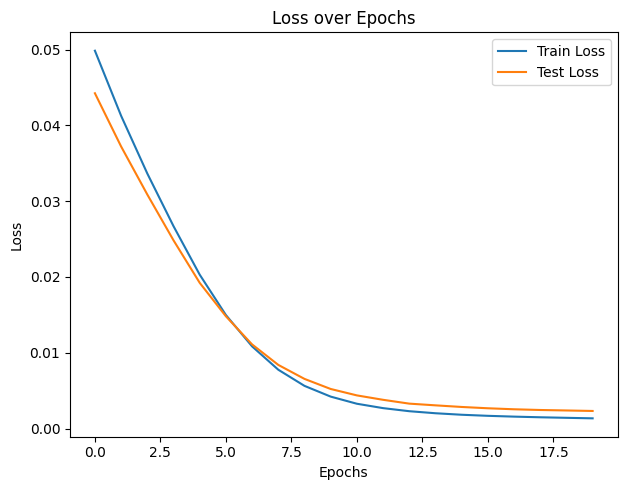

In [10]:
# 可视化结果
def show(train_loss_list, test_loss_list, train_accuracy_list=None, test_accuracy_list=None):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
     
    if train_accuracy_list != None:
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_list, label='Train Accuracy')
        plt.plot(test_accuracy_list, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
show(train_loss_list, test_loss_list)

### 二分类任务

In [11]:
# 数据集参数
size = 10000
train_size = 7000
test_size = 3000
feature_dim = 200
mean1, mean2 = 1, -1
std = 1

# 生成特征
features1 = np.random.normal(mean1, std, (size, feature_dim))
features2 = np.random.normal(mean2, std, (size, feature_dim))

# 生成标签
labels1 = np.zeros(size)
labels2 = np.ones(size)

# 划分训练集和测试集
train_features1, test_features1 = features1[:train_size], features1[train_size:]
train_labels1, test_labels1 = labels1[:train_size], labels1[train_size:]

train_features2, test_features2 = features2[:train_size], features2[train_size:]
train_labels2, test_labels2 = labels2[:train_size], labels2[train_size:]

# 拼接
train_features = np.concatenate((train_features1, train_features2), axis=0)
train_labels = np.concatenate((train_labels1, train_labels2), axis=0)
test_features = np.concatenate((test_features1, test_features2), axis=0)
test_labels = np.concatenate((test_labels1, test_labels2), axis=0)

# 转换为 PyTorch 张量
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# 创建 TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# 创建 DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 测试
for i, (X, y) in enumerate(train_loader):
    print("Dataset - Train Batch:", X.shape, y.shape)
    # print(y)
    break
for X, y in test_loader:
    print("Dataset - Test Batch:", X.shape, y.shape)
    # print(y)
    break

Dataset - Train Batch: torch.Size([256, 200]) torch.Size([256])
Dataset - Test Batch: torch.Size([256, 200]) torch.Size([256])


In [13]:
# 定义超参数
lr = 0.03
num_epochs = 20

model = FFN(num_inputs=feature_dim, num_outputs=1, num_hiddens=feature_dim*2)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 定义准确率
def accuracy(y_hat, y):
    y = y.reshape(-1, 1)
    return ((y_hat > 0.5).float() == y).float().mean().item()


def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    # 记录训练时间
    start_time = time.time()
    
    # 记录训练和测试的损失和准确率
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        test_loss = 0
        test_accuracy = 0
        train_batch_num = 0
        test_batch_num = 0

        for X, y in train_loader:
            pred = model(X)
            y = y.reshape(-1, 1).float()
            loss = loss_fn(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
            train_batch_num += 1

        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                y = y.reshape(-1, 1).float()
                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
                test_batch_num += 1

        train_loss /= train_batch_num
        train_accuracy /= train_batch_num          
        test_loss /= test_batch_num
        test_accuracy /= test_batch_num
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    print(f'Training time: {time.time() - start_time:.2f}s')
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

Epoch [1/20], Train Loss: 0.4066, Train Accuracy: 0.7997, Test Loss: 0.1526, Test Accuracy: 1.0000
Epoch [2/20], Train Loss: 0.0786, Train Accuracy: 1.0000, Test Loss: 0.0396, Test Accuracy: 1.0000
Epoch [3/20], Train Loss: 0.0275, Train Accuracy: 1.0000, Test Loss: 0.0192, Test Accuracy: 1.0000
Epoch [4/20], Train Loss: 0.0152, Train Accuracy: 1.0000, Test Loss: 0.0120, Test Accuracy: 1.0000
Epoch [5/20], Train Loss: 0.0101, Train Accuracy: 1.0000, Test Loss: 0.0085, Test Accuracy: 1.0000
Epoch [6/20], Train Loss: 0.0074, Train Accuracy: 1.0000, Test Loss: 0.0065, Test Accuracy: 1.0000
Epoch [7/20], Train Loss: 0.0058, Train Accuracy: 1.0000, Test Loss: 0.0052, Test Accuracy: 1.0000
Epoch [8/20], Train Loss: 0.0047, Train Accuracy: 1.0000, Test Loss: 0.0043, Test Accuracy: 1.0000
Epoch [9/20], Train Loss: 0.0040, Train Accuracy: 1.0000, Test Loss: 0.0036, Test Accuracy: 1.0000
Epoch [10/20], Train Loss: 0.0034, Train Accuracy: 1.0000, Test Loss: 0.0032, Test Accuracy: 1.0000
Epoch [11

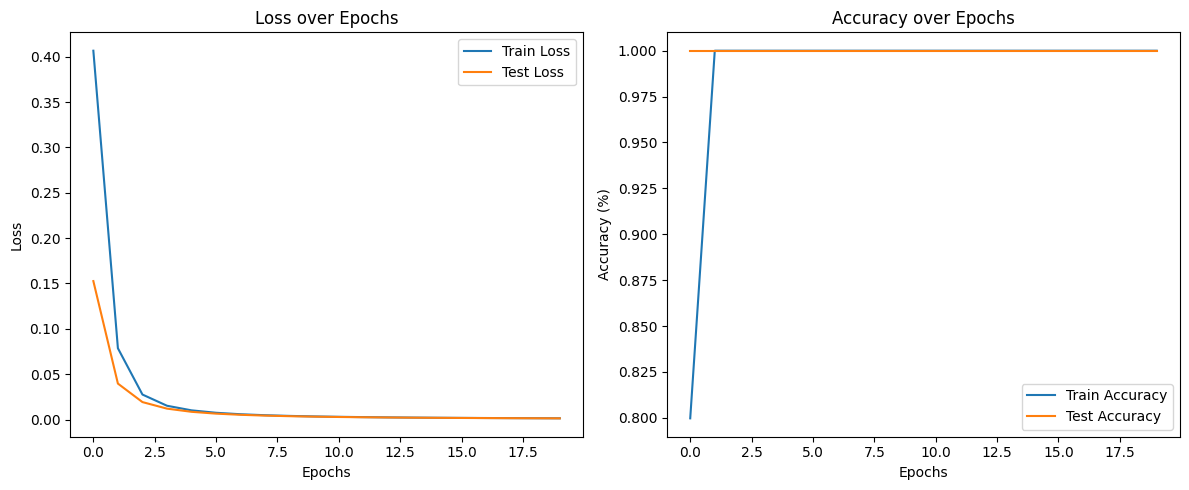

In [14]:
show(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list)

### 多分类任务

In [15]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 下载MINIST手写数字数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for X,y in train_loader:
    print(X.shape, y.shape)
    break

# 定义准确率
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == y).float().mean().item()

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [17]:
# 定义超参数
lr = 0.03
num_epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens=256).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    # 记录训练时间
    start_time = time.time()
    
    # 记录训练和测试的损失和准确率
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        test_loss = 0
        test_accuracy = 0
        train_batch_num = 0
        test_batch_num = 0

        for X, y in train_loader:
            X = X.view(-1, 28*28).to(device)
            y = y.to(device)
            pred = model(X)
            
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
            train_batch_num += 1

        with torch.no_grad():
            for X, y in test_loader:
                X = X.view(-1, 28*28).to(device)
                y = y.to(device)
                pred = model(X)

                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
                test_batch_num += 1

        train_loss /= train_batch_num
        train_accuracy /= train_batch_num          
        test_loss /= test_batch_num
        test_accuracy /= test_batch_num
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    print(f'Training time: {time.time() - start_time:.2f}s')
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

cuda
Epoch [1/20], Train Loss: 2.2666, Train Accuracy: 0.3936, Test Loss: 2.2042, Test Accuracy: 0.5152
Epoch [2/20], Train Loss: 2.0475, Train Accuracy: 0.5884, Test Loss: 1.8050, Test Accuracy: 0.6727
Epoch [3/20], Train Loss: 1.5082, Train Accuracy: 0.7155, Test Loss: 1.1968, Test Accuracy: 0.7693
Epoch [4/20], Train Loss: 1.0268, Train Accuracy: 0.7856, Test Loss: 0.8496, Test Accuracy: 0.8133
Epoch [5/20], Train Loss: 0.7774, Train Accuracy: 0.8235, Test Loss: 0.6749, Test Accuracy: 0.8388
Epoch [6/20], Train Loss: 0.6452, Train Accuracy: 0.8440, Test Loss: 0.5758, Test Accuracy: 0.8587
Epoch [7/20], Train Loss: 0.5658, Train Accuracy: 0.8591, Test Loss: 0.5129, Test Accuracy: 0.8708
Epoch [8/20], Train Loss: 0.5128, Train Accuracy: 0.8689, Test Loss: 0.4694, Test Accuracy: 0.8799
Epoch [9/20], Train Loss: 0.4759, Train Accuracy: 0.8761, Test Loss: 0.4376, Test Accuracy: 0.8867
Epoch [10/20], Train Loss: 0.4479, Train Accuracy: 0.8818, Test Loss: 0.4133, Test Accuracy: 0.8896
Epoc

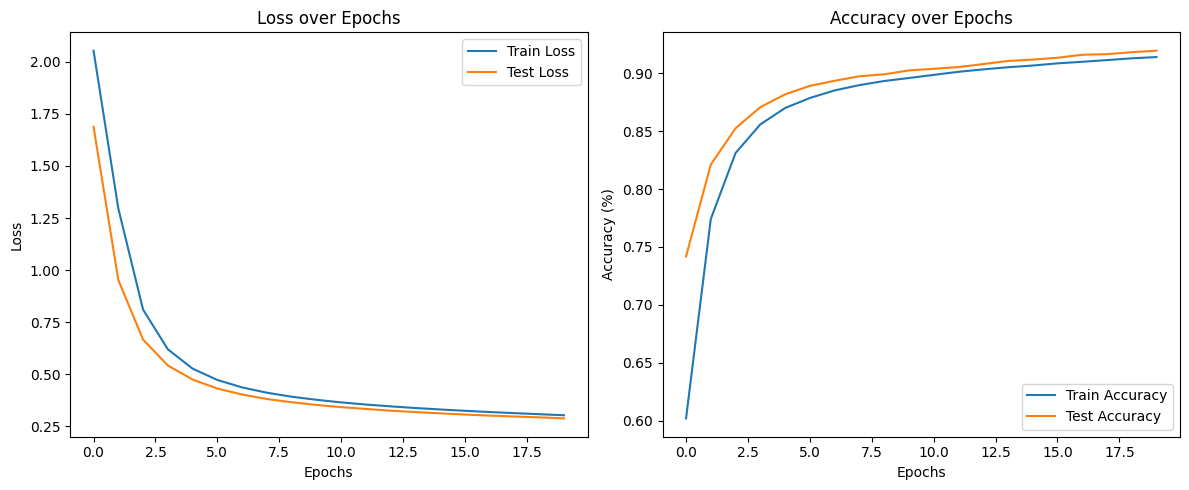

In [14]:
show(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list)